<a href="https://colab.research.google.com/github/Nahmadid/WeeklyReport/blob/main/pharma_inverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Array([[10.7365,  0.    ,  0.    ,  0.    ]], dtype=float32)

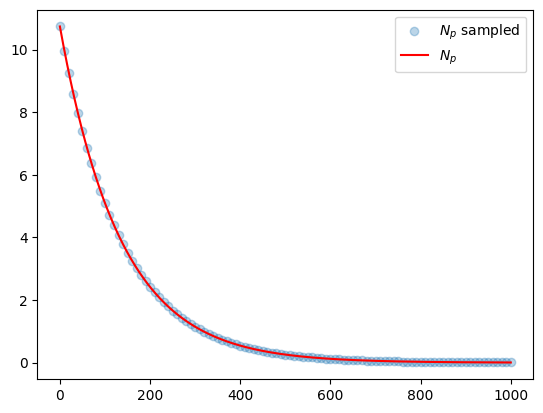

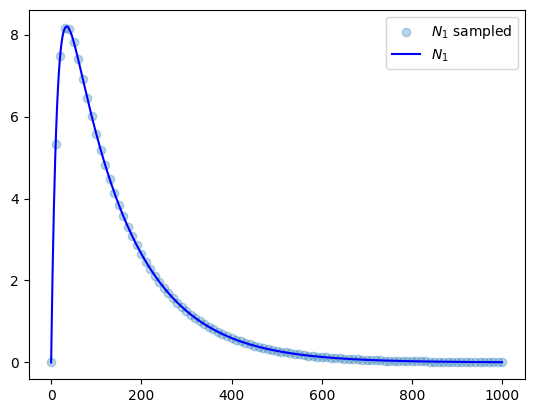

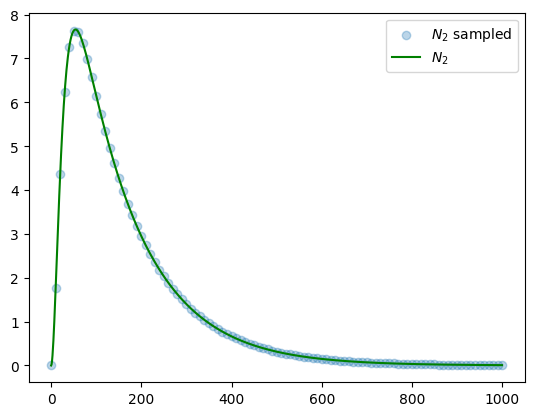

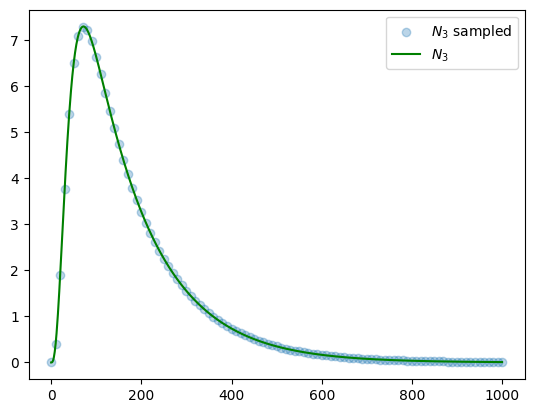

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import sys
# import jaxopt

#@title **Doxorubicin**

import numpy as np
from scipy.integrate import odeint

#Defining the model
def Pharma(
    t,
    l0 = 0.0292 ,
    k1 = 0.0743 ,
    k2 = 0.0745,
    c  = 0.492,
):
    def func(y, t):
        return [
            l0 * y[0] - k2 * c * y[0],
            k2 * c * y[0] - k1 * y[1],
            k1 * y[1] - k1 * y[2],
            k1 * y[2] - k1 * y[3],
        ]

    # defining initial conditions for 6 state variables
    y0 = [2147.3, 0, 0, 0]
    return odeint(func, y0, t)




# t = np.arange(0, 1000, 1)[:, None]
# y = Pharma(np.ravel(t))

t_dense = jnp.linspace(0, 1000, 1001)[:, None]
y_dense_org = Pharma(np.ravel(t_dense))

scale_factor = [200,100,100,100]
y_dense = y_dense_org/scale_factor

sample_rate = 10
t_data = t_dense[::sample_rate,0:1]
Np_data = y_dense[::sample_rate,0:1]
N1_data = y_dense[::sample_rate,1:2]
N2_data = y_dense[::sample_rate,2:3]
N3_data = y_dense[::sample_rate,3:4]


data = jnp.concatenate([Np_data, N1_data, N2_data, N3_data], axis=1)
t_i  = jnp.array([[0]])
IC   = jnp.concatenate([Np_data[0:1,:], N1_data[0:1,:], N2_data[0:1,:], N3_data[0:1,:]], axis=1)
# plt.figure()
plt.scatter(t_data, data[:,0:1], alpha=0.3,label='$N_p$ sampled')
plt.plot(t_dense,y_dense[:,0],'-r',label='$N_p$')
plt.legend()
plt.figure()
plt.scatter(t_data, data[:,1:2], alpha=0.3,label='$N_1$ sampled')
plt.plot(t_dense,y_dense[:,1],'-b',label='$N_1$')
plt.legend()
plt.figure()
plt.scatter(t_data, data[:,2:3], alpha=0.3,label='$N_2$ sampled')
plt.plot(t_dense,y_dense[:,2],'-g',label='$N_2$')
plt.legend()
plt.figure()
plt.scatter(t_data, data[:,3:4], alpha=0.3,label='$N_3$ sampled')
plt.plot(t_dense,y_dense[:,3],'-g',label='$N_3$')
plt.legend()
IC

In [ ]:
#@title **separate loss (na joda! oonam joda joda)**

# tmin,tmax=0.
tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(6123), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B , 'k1': 0.0 , 'k2': 0.0, 'l0': 0.0})
        # params.append({'W': W, 'B': B })
    return params


# def init_params(layers):
#     keys = jax.random.split(jax.random.PRNGKey(6123), len(layers) - 1)
#     params = []
#     for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
#         W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
#         B = jax.random.normal(key, shape=(n_out,))
#         params.append({'W': W, 'B': B , 'kb': 0.5 , 'kg': 0.5})
#     return params


def fwd(params,t):
  t = 0.01 * t
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

def fwd_extra(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  X = X@last['W'] + last['B']
  return X



@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)




In [ ]:


def ODE_loss(t, params, yp, y1, y2, y3, ft, gt):
    # l0 = 0.0292
    # k1 = 0.0743
    # k2 = 0.0745

    l0 = params[0]['l0']/10
    k1 = params[0]['k1']/10
    k2_p = params[0]['k2']/10
    # c  = params[0]['c']/10
    # c = 0.492
    #ft = (k1 * N2 - k1 * N3)

    Np = yp(t)*scale_factor[0]
    N1 = y1(t)*scale_factor[1]
    N2 = y2(t)*scale_factor[2]
    N3 = y3(t)*scale_factor[3]

    yp_t = lambda t: jax.grad(lambda t: jnp.sum(yp(t)))(t)
    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)

    # odep = yp_t(t) - 1/scale_factor[0]* ft(t)
    # ode1 = y1_t(t) - 1/scale_factor[1]* gt(t)
    odep = yp_t(t) - 1/scale_factor[0]*(l0 * Np - k2_p * Np)
    ode1 = y1_t(t) - 1/scale_factor[1]*(k2_p * Np - k1 * N1)
    ode2 = y2_t(t) - 1/scale_factor[2]* (k1 * N1 - k1 * N2)
    ode3 = y3_t(t) - 1/scale_factor[3]* (k1 * N2 - k1 * N3)


    return odep, ode1, ode2, ode3




#collocation points
N_c = 1000

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params,params_extra, lp, l1 ,l2 ,l3 , t_i, t_d, t_c, data_IC, data):

    yp_func = lambda t: fwd(params, t)[:, [0]]
    y1_func = lambda t: fwd(params, t)[:, [1]]
    y2_func = lambda t: fwd(params, t)[:, [2]]
    y3_func = lambda t: fwd(params, t)[:, [3]]

    ft     = lambda t: fwd_extra(params_extra, t)[:, [0]]
    gt     = lambda t: fwd_extra(params_extra, t)[:, [1]]
    # ft     = lambda t: fwd(params, t)[:, [4]]
    # gt     = lambda t: fwd(params, t)[:, [5]]

    # loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func, f_t)
    loss_yp, loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, yp_func, y1_func, y2_func, y3_func, ft,gt)

    loss_yp = lp*loss_yp
    loss_y1 = l1*loss_y1
    loss_y2 = l2*loss_y2
    loss_y3 = l3*loss_y3

    loss_odep = jnp.mean(loss_yp ** 2)
    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)


    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([yp_func(t_i),y1_func(t_i), y2_func(t_i), y3_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([yp_func(t_d) ,y1_func(t_d), y2_func(t_d), y3_func(t_d)],axis=1)
    loss_data = MSE(data, pred_d)

    #loss_data = MSE(data[:,0:3], pred_d[:,0:3])
    # loss_data = MSE(data[:, [0, 3]], pred_d[:, [0, 2]])


    return loss_IC, loss_data, loss_odep, loss_ode1, loss_ode2, loss_ode3


# def loss_fun_total(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data, loss_weight):

#     loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data)

#     loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
#                 + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
#                 + loss_weight[4]*loss_ode3

#     return loss_total


def loss_fun_total(params, params_extra, lp, l1,l2, l3, t_i, t_d, t_c, data_IC, data, loss_weight):

    loss_IC, loss_data, loss_odep, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra, lp ,l1,l2, l3, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_odep+ loss_weight[3]*loss_ode1+ loss_weight[4]*loss_ode2\
                + loss_weight[5]*loss_ode3

    return loss_total






# @jax.jit
# def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight):
#   grads=jax.grad(loss_fun_total, argnums=[0,1,2,3,4])(params, params_extra,params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)

#   #Update params
#   updates, opt_state = optimizer.update(grads[0], opt_state)
#   params = optax.apply_updates(params, updates)

#   updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
#   params_extra = optax.apply_updates(params_extra, updates_extra)

#   updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
#   params_l1 = optax.apply_updates(params_l1, updates_l1)

#   updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
#   params_l2 = optax.apply_updates(params_l2, updates_l2)

#   updates_l3, opt_state_l3 = optimizer.update(-grads[4], opt_state_l3)
#   params_l3 = optax.apply_updates(params_l3, updates_l3)

#   return opt_state,params,opt_state_extra,params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3




@jax.jit
def update(opt_state, opt_state_extra, params, params_extra, params_lp, params_l1, params_l2, params_l3, opt_state_lp, opt_state_l1, opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1,2,3,4,5])(params,params_extra, params_lp, params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
  params_extra = optax.apply_updates(params_extra, updates_extra)

  updates_lp, opt_state_lp = optimizer.update(-grads[2], opt_state_lp)
  params_lp = optax.apply_updates(params_lp, updates_lp)

  updates_l1, opt_state_l1 = optimizer.update(-grads[3], opt_state_l1)
  params_l1 = optax.apply_updates(params_l1, updates_l1)

  updates_l2, opt_state_l2 = optimizer.update(-grads[4], opt_state_l2)
  params_l2 = optax.apply_updates(params_l2, updates_l2)

  updates_l3, opt_state_l3 = optimizer.update(-grads[5], opt_state_l3)
  params_l3 = optax.apply_updates(params_l3, updates_l3)

  return opt_state, opt_state_extra, params, params_extra, params_lp, params_l1, params_l2, params_l3, opt_state_lp, opt_state_l1, opt_state_l2, opt_state_l3





In [ ]:
# construct the MLP of  4 hidden layers of 8 neurons for each layer
params = init_params([1] + [32]*6+[4])
params_extra = init_params([1] + [20]*4+[1])  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
optimizer_ex = optax.adam(1e-3)
opt_state_extra = optimizer_ex.init(params_extra)


keys = jax.random.split(jax.random.PRNGKey(0), 10)
lambda_p = jax.random.uniform(keys[0], shape=(N_c + 1, 1))
lambda_1 = jax.random.uniform(keys[1], shape=(N_c + 1, 1))
lambda_2 = jax.random.uniform(keys[2], shape=(N_c + 1, 1))
lambda_3 = jax.random.uniform(keys[3], shape=(N_c + 1, 1))


opt_state_lp = optimizer.init(lambda_p)
opt_state_l1 = optimizer.init(lambda_1)
opt_state_l2 = optimizer.init(lambda_2)
opt_state_l3 = optimizer.init(lambda_3)


In [ ]:
#@title **two step training**


# start_time = time.time()
epochs_phase1 = 10000
epochs_phase2 = 100000
# loss_weight_phase1 = [1, 1, 1, 1, 1, 1]
loss_weight_phase1 = [1, 1, 0, 0, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1, 1, 1]

loss_his, loss_indi_his, epoch_his = [], [], []
l0_values_list = []
k1_values_list = []
k2_values_list = []

for ep in range(epochs_phase1 + epochs_phase2 + 1):
    if ep <= epochs_phase1:
        loss_weight = loss_weight_phase1
    else:
        loss_weight = loss_weight_phase2

    opt_state,opt_state_extra, params,params_extra, params_lp,\
     params_l1, params_l2, params_l3, opt_state_lp,\
      opt_state_l1, opt_state_l2, opt_state_l3= update(opt_state,opt_state_extra, params, params_extra, lambda_p, lambda_1, lambda_2, lambda_3,\
                                                       opt_state_lp, opt_state_l1,opt_state_l2, opt_state_l3,\
                                                       t_i, t_data, t_c, IC, data, loss_weight)

    # print loss and epoch info
    if ep %(1000) ==0:
      loss_val = loss_fun_total(params, params_extra, params_lp, params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)
      loss_val_individual = loss_fun(params, params_extra, params_lp, params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data)
      epoch_his.append(ep)
      loss_his.append(loss_val)
      loss_indi_his.append(loss_val_individual)

      l0_updated = params[0]['l0']/10
      k1_updated = params[0]['k1']/10
      k2_updated = params[0]['k2']/10
      # c_updated  = params[0]['c']/10

      print(f'Epoch={ep}, \t l0= {l0_updated:.5f} , \t k1= {k1_updated:.5f} ,\t k2={k2_updated:.5f} ,\t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_ep={loss_val_individual[2]:.2e},\t loss_e1={loss_val_individual[3]:.2e}, \t loss_e2={loss_val_individual[4]:.2e}, \t loss_e3={loss_val_individual[5]:.2e}')
      # Append the values directly to the lists
      # kb_values_list.append(kb_updated)
      # kg_values_list.append(kg_updated)
      # np.savez(f'/content/drive/MyDrive/params_100_{ep}.npz', *params)

# end_time = time.time()

# running_time = end_time - start_time
# print(f"Total running time: {running_time:.2f} seconds")


Epoch=0, 	 l0= 0.00000 , 	 k1= 0.00000 ,	 k2=0.00000 ,	 loss=3.29e+01, 	 loss_IC=2.41e+01, 	 loss_d=8.80e+00, 	 loss_ep=1.82e-09,	 loss_e1=8.52e-11, 	 loss_e2=1.44e-09, 	 loss_e3=1.24e-09
Epoch=1000, 	 l0= 0.00000 , 	 k1= 0.00000 ,	 k2=0.00000 ,	 loss=4.38e-02, 	 loss_IC=3.67e-04, 	 loss_d=4.34e-02, 	 loss_ep=1.58e-04,	 loss_e1=7.34e-04, 	 loss_e2=5.65e-04, 	 loss_e3=3.01e-04
Epoch=2000, 	 l0= 0.00000 , 	 k1= 0.00000 ,	 k2=0.00000 ,	 loss=6.30e-03, 	 loss_IC=2.69e-05, 	 loss_d=6.27e-03, 	 loss_ep=1.50e-04,	 loss_e1=1.01e-03, 	 loss_e2=5.98e-04, 	 loss_e3=3.37e-04
Epoch=3000, 	 l0= 0.00000 , 	 k1= 0.00000 ,	 k2=0.00000 ,	 loss=1.33e-03, 	 loss_IC=3.80e-06, 	 loss_d=1.33e-03, 	 loss_ep=1.49e-04,	 loss_e1=7.91e-04, 	 loss_e2=4.76e-04, 	 loss_e3=3.61e-04
Epoch=4000, 	 l0= 0.00000 , 	 k1= 0.00000 ,	 k2=0.00000 ,	 loss=1.74e-04, 	 loss_IC=2.23e-07, 	 loss_d=1.73e-04, 	 loss_ep=1.54e-04,	 loss_e1=7.21e-04, 	 loss_e2=4.48e-04, 	 loss_e3=3.71e-04
Epoch=5000, 	 l0= 0.00000 , 	 k1= 0.00000 ,	 k2=

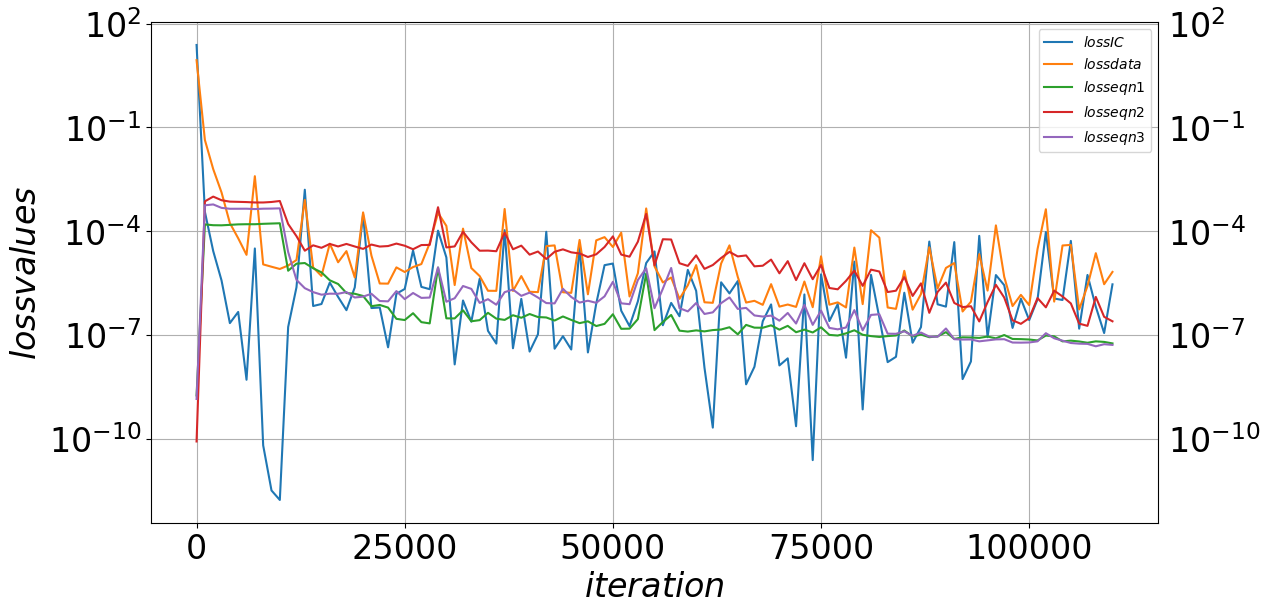

In [ ]:
SAVE_FIG = False
#History of loss
font = 24
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,0], label='$loss IC$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,1], label='$loss data$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,2], label='$loss eqn1$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,3], label='$loss eqn2$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,4], label='$loss eqn3$')
plt.legend(loc="upper right",  fontsize = 24, ncol=4)
plt.legend()
ax.tick_params(axis='both', labelsize = 24)
fig.set_size_inches(w=13,h=6.5)
if SAVE_FIG:
    plt.savefig(save_results_to +'History_loss.png', dpi=300)



<Figure size 640x480 with 0 Axes>

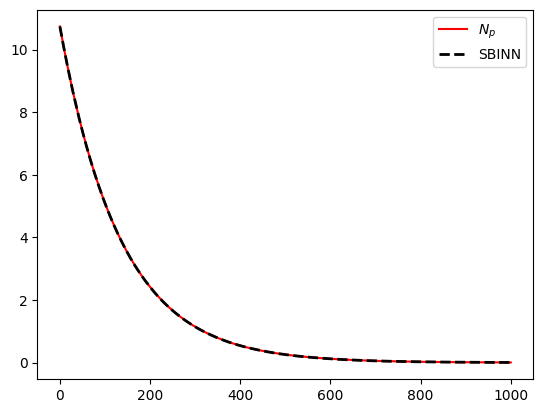

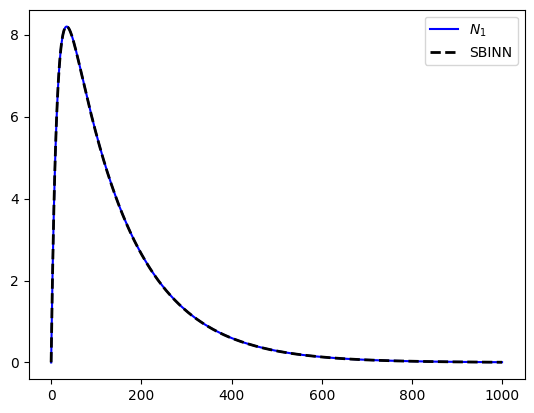

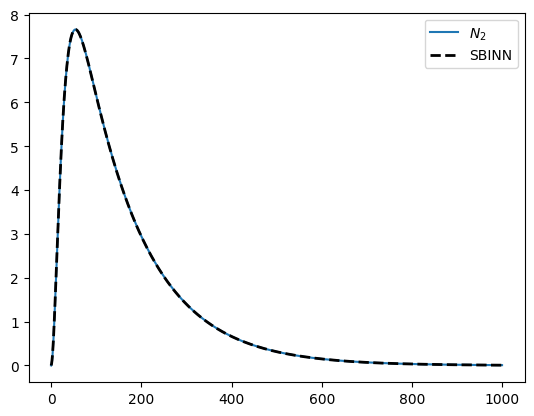

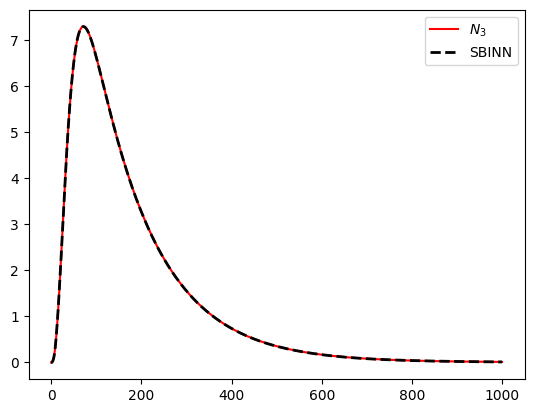

<Figure size 640x480 with 0 Axes>

In [ ]:

# # import pandas as pd
# with np.load('/content/drive/MyDrive/params_100_62000.npz', allow_pickle=True) as data:
#     loaded_params = [dict(data[name].item()) for name in data.files]

# with np.load('/content/drive/MyDrive/params_extra_100_62000.npz', allow_pickle=True) as data:
#     loaded_params_extra = [dict(data[name].item()) for name in data.files]



pred = fwd(params,t_dense)
plt.plot(t_dense,y_dense[:,0],'r',label='$N_p$')
plt.plot(t_dense,pred[:,0],'--k',label='SBINN',linewidth=2)

plt.legend()
plt.figure()
plt.plot(t_dense,y_dense[:,1],'b',label='$N_1$')
plt.plot(t_dense,pred[:,1],'--k',label='SBINN',linewidth=2)

plt.legend()
plt.figure()
plt.plot(t_dense,y_dense[:,2],label='$N_2$')
plt.plot(t_dense,pred[:,2],'--k',label='SBINN',linewidth=2)

plt.legend()
plt.figure()
plt.plot(t_dense,y_dense[:,3],'r',label='$N_3$')
plt.plot(t_dense,pred[:,3],'--k',label='SBINN',linewidth=2)
plt.legend()


# # f_t =fwd(loaded_params_extra, t_dense)
# f_t =fwd_extra(loaded_params_extra, t_dense)*10
# G_pred = pred[:,0:1]*10
# B_pred = pred[:,1:2]*10
# df_f = pd.DataFrame({"t": np.ravel(t_dense),"G": np.ravel(G_pred), "B": np.ravel(B_pred), "ft": np.ravel(f_t) })
# df_f.to_csv("/content/drive/MyDrive/ft_combined_100.csv", index=False)

# # df_g = pd.DataFrame({"t": np.ravel(t_dense),"Ip": np.ravel(Ip_pred), "Ii": np.ravel(Ii_pred), "gt": np.ravel(g_t_pred) })
# # df_g.to_csv("/content/drive/MyDrive/gt_250_19.csv", index=False)


# plt.legend()
plt.figure()



# kg = 0.72
# kb = 0.15
# G0 = 0.1

# # Calculate f_t using the provided equations
# f_t_analytical = kg * y_dense[:, 0] - kb * y_dense[:, 1]*10
# f_t_neural = fwd_extra(loaded_params_extra, t_dense)[:, 0]*10

# f_t_err = f_t_analytical - f_t_neural
# # F_SR= 0.739 *y_dense[:, 0]- 0.141* y_dense[:, 1]
# F_SR= 0.712 *y_dense[:, 0]#- 0.141* y_dense[:, 1]
# # f_t_neural = fwd_extra(loaded_params_extra, t_dense)[:, 0]
# # Plot both f_t values
# plt.plot(t_dense, f_t, label='$f(t)$ (exact) = 0.72 G + 0.15 B')
# plt.plot(t_dense, f_t_neural,'r',linewidth=2, label='f(t) PINN', alpha=0.3)
# # plt.plot(t_dense, f_t_err,'--b',linewidth=2, label='f(t) PINN', alpha=0.3)
# # plt.plot(t_dense, F_SR ,'--k', label='$f(t)$ (Symbolic Regression)= 0.739 G + 0.141 B ')
# plt.grid()
# plt.xlabel('t')
# plt.ylabel('$f(t)$')
# plt.title('Result of 100 data points')
# plt.legend()
# plt.show()



# # plt.plot(T,fwd(params_extra,T.reshape(-1,1)),'--k',label='NN[G]',linewidth=2)

# plt.legend()
